Rozmiar bazowego zbioru treningowego: 400
Rozmiar CZYSTEGO zbioru testowego: 100
Liczba próbek z szumem w zbiorze treningowym: 40

--- Podsumowanie Dokładności ---
RF Czyste: 0.9700 | RF Zaszumione: 0.9800 | Spadek RF: -0.0100
XGB Czyste: 0.9900 | XGB Zaszumione: 0.8800 | Spadek XGB: 0.1100


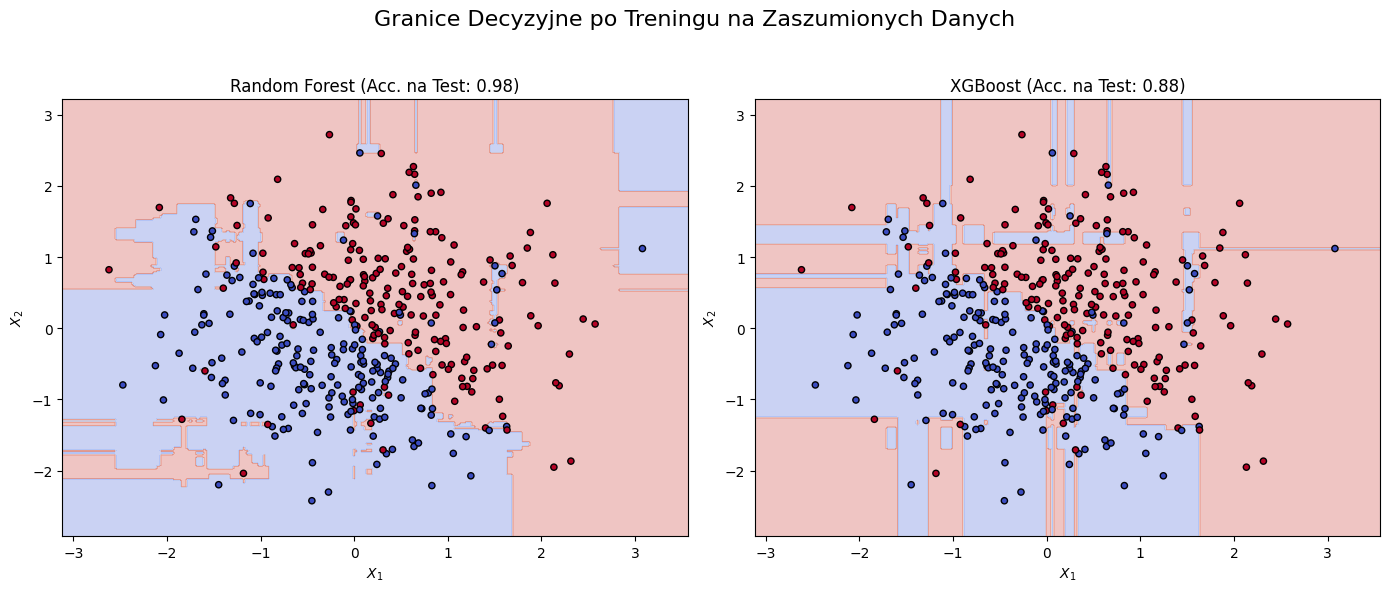

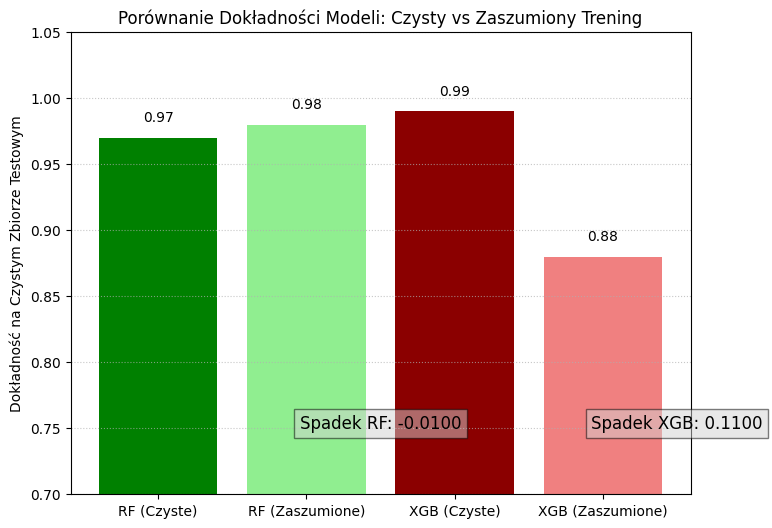

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(42)

# =========================================================================
# 1. PRZYGOTOWANIE DANYCH
# =========================================================================
X = np.random.randn(500, 2)
y_clean = (X[:, 0] + X[:, 1] > 0).astype(int)

X_train_base, X_test, y_train_base, y_test = train_test_split(
    X, y_clean, test_size=0.2, random_state=42
)

y_train_noisy = np.copy(y_train_base)
noise_fraction = 0.1
num_noise_samples = int(len(y_train_noisy) * noise_fraction)
noise_indices = np.random.choice(len(y_train_noisy), num_noise_samples, replace=False)
y_train_noisy[noise_indices] = 1 - y_train_noisy[noise_indices]

print(f"Rozmiar bazowego zbioru treningowego: {len(X_train_base)}")
print(f"Rozmiar CZYSTEGO zbioru testowego: {len(X_test)}")
print(f"Liczba próbek z szumem w zbiorze treningowym: {num_noise_samples}")

# =========================================================================
# 2. TRENOWANIE MODELLI
# =========================================================================
rf_clean = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clean = XGBClassifier(eval_metric='logloss', random_state=42)

rf_clean.fit(X_train_base, y_train_base)
xgb_clean.fit(X_train_base, y_train_base)

rf_noisy = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_noisy = XGBClassifier(eval_metric='logloss', random_state=42)

rf_noisy.fit(X_train_base, y_train_noisy)
xgb_noisy.fit(X_train_base, y_train_noisy)

# =========================================================================
# 3. OCENA I WYNIKI
# =========================================================================
acc_rf_clean = accuracy_score(y_test, rf_clean.predict(X_test))
acc_xgb_clean = accuracy_score(y_test, xgb_clean.predict(X_test))
acc_rf_noisy = accuracy_score(y_test, rf_noisy.predict(X_test))
acc_xgb_noisy = accuracy_score(y_test, xgb_noisy.predict(X_test))

drop_rf = acc_rf_clean - acc_rf_noisy
drop_xgb = acc_xgb_clean - acc_xgb_noisy

print("\n--- Podsumowanie Dokładności ---")
print(f"RF Czyste: {acc_rf_clean:.4f} | RF Zaszumione: {acc_rf_noisy:.4f} | Spadek RF: {drop_rf:.4f}")
print(f"XGB Czyste: {acc_xgb_clean:.4f} | XGB Zaszumione: {acc_xgb_noisy:.4f} | Spadek XGB: {drop_xgb:.4f}")


# =========================================================================
# 4. WIZUALIZACJA GRANIC DECYZYJNYCH
# =========================================================================
def plot_decision_boundary(model, X, y, title, ax):
    """Rysuje granicę decyzyjną dla modelu."""
    h = .02  # krok siatki
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k', s=20)
    ax.set_title(title)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Granice Decyzyjne po Treningu na Zaszumionych Danych', fontsize=16)

plot_decision_boundary(rf_noisy, X_train_base, y_train_noisy, 
                       f'Random Forest (Acc. na Test: {acc_rf_noisy:.2f})', axes[0])

plot_decision_boundary(xgb_noisy, X_train_base, y_train_noisy, 
                       f'XGBoost (Acc. na Test: {acc_xgb_noisy:.2f})', axes[1])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# =========================================================================
# 5. WIZUALIZACJA PORÓWNANIA DOKŁADNOŚCI
# =========================================================================

models = ['RF (Czyste)', 'RF (Zaszumione)', 'XGB (Czyste)', 'XGB (Zaszumione)']
accuracies = [acc_rf_clean, acc_rf_noisy, acc_xgb_clean, acc_xgb_noisy]
colors = ['green', 'lightgreen', 'darkred', 'lightcoral']
spadki = [drop_rf, drop_xgb]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(models, accuracies, color=colors)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

ax.text(1.5, 0.75, f"Spadek RF: {drop_rf:.4f}", ha='center', color='black', fontsize=12, 
        bbox=dict(facecolor='lightgray', alpha=0.5))
ax.text(3.5, 0.75, f"Spadek XGB: {drop_xgb:.4f}", ha='center', color='black', fontsize=12, 
        bbox=dict(facecolor='lightgray', alpha=0.5))

ax.set_ylim(0.7, 1.05)
ax.set_title('Porównanie Dokładności Modeli: Czysty vs Zaszumiony Trening')
ax.set_ylabel('Dokładność na Czystym Zbiorze Testowym')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()